In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import tensorflow as tf
from tensorflow import keras
import holidays
from sklearn import preprocessing
import xgboost
from xgboost import XGBRegressor

In [2]:
transactions = pd.read_csv("../data/occurences.csv")

In [3]:
transactions.head()

,ITEM_NUMBER,DATE,TIME,SOLDUNITS
0,844600,8/14/13,8:40:14,2.85714
1,844600,8/16/13,15:16:10,15.60000
2,844600,8/16/13,15:19:22,15.60000
3,844600,8/16/13,17:04:11,716.91429
4,844600,8/16/13,17:09:59,153.14286


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ITEM_NUMBER  77409 non-null  int64  
 1   DATE         77409 non-null  object 
 2   TIME         77409 non-null  object 
 3   SOLDUNITS    77409 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [5]:
#transactions.rename(columns={"DATE.1": "SOLDUNITS"},
#errors="raise", inplace=True)

### Adding year, week and day columns

In [6]:
transactions['YEAR'] = pd.to_datetime(transactions['DATE']).dt.year
transactions['MONTH'] = pd.to_datetime(transactions['DATE']).dt.month
transactions['WEEK'] = pd.to_datetime(transactions['DATE']).dt.week
transactions['DAY'] = pd.to_datetime(transactions['DATE']).dt.day

/tmp/ipykernel_15829/3452146495.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  transactions['WEEK'] = pd.to_datetime(transactions['DATE']).dt.week


In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ITEM_NUMBER  77409 non-null  int64  
 1   DATE         77409 non-null  object 
 2   TIME         77409 non-null  object 
 3   SOLDUNITS    77409 non-null  float64
 4   YEAR         77409 non-null  int64  
 5   MONTH        77409 non-null  int64  
 6   WEEK         77409 non-null  int64  
 7   DAY          77409 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 4.7+ MB


In [8]:
transactions.head()

,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY
0,844600,8/14/13,8:40:14,2.85714,2013,8,33,14
1,844600,8/16/13,15:16:10,15.60000,2013,8,33,16
2,844600,8/16/13,15:19:22,15.60000,2013,8,33,16
3,844600,8/16/13,17:04:11,716.91429,2013,8,33,16
4,844600,8/16/13,17:09:59,153.14286,2013,8,33,16


### Including holidays

In [9]:
us_holidays = []

for date in holidays.UnitedStates(years = transactions['YEAR']).items():
    us_holidays.append(str(date[0]))

In [10]:
print(us_holidays,end=', ')

['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-11', '2017-11-10', '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-11', '2018-11-12', '2018-11-22', '2018-12-25', '2019-01-01', '2019-01-21', '2019-02-18', '2019-05-27', '2019-07-04', '2019-09-02', '2019-10-14', '2019-11-11', '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20', '2020-02-17', '2020-05-25', '2020-07-04', '2020-07-03', '2020-09-07', '2020-10-12', '2020-11-11', '2020-11-26', '2020-12-25', '2021-01-01', '2021-12-31', '2021-01-18', '2021-02-15', '2021-05-31', '2021-07-04', '2021-07-05', '2021-09-06', '2021-10-11', '2021-11-11', '2021-11-25', '2021-12-25', '2021-12-24', '2022-01-01', '2022-01-17', '2022-02-21', '2022

In [11]:
print([1 if str(val).split()[0] in us_holidays else 0 for val in transactions['DATE']],end = ', ')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
transactions['IS_HOLIDAY'] = [1 if str(val).split()[0] in us_holidays else 0 for val in 
                             transactions['DATE']]

In [13]:
transactions.head()

,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY
0,844600,8/14/13,8:40:14,2.85714,2013,8,33,14,0
1,844600,8/16/13,15:16:10,15.60000,2013,8,33,16,0
2,844600,8/16/13,15:19:22,15.60000,2013,8,33,16,0
3,844600,8/16/13,17:04:11,716.91429,2013,8,33,16,0
4,844600,8/16/13,17:09:59,153.14286,2013,8,33,16,0


In [14]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ITEM_NUMBER  77409 non-null  int64  
 1   DATE         77409 non-null  object 
 2   TIME         77409 non-null  object 
 3   SOLDUNITS    77409 non-null  float64
 4   YEAR         77409 non-null  int64  
 5   MONTH        77409 non-null  int64  
 6   WEEK         77409 non-null  int64  
 7   DAY          77409 non-null  int64  
 8   IS_HOLIDAY   77409 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 5.3+ MB


### Including seasons

In [15]:
# Winter = 1
# Spring = 2
# Summer = 3
# Fall = 4
season_dict = {1: 1,
               2: 1,
               3: 2, 
               4: 2,
               5: 2,
               6: 3,
               7: 3,
               8: 3,
               9: 4,
               10: 4,
               11: 4,
               12: 1}
transactions['SEASON'] = transactions['MONTH'].apply(lambda x: season_dict[x])

In [16]:
transactions.head()

,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
0,844600,8/14/13,8:40:14,2.85714,2013,8,33,14,0,3
1,844600,8/16/13,15:16:10,15.60000,2013,8,33,16,0,3
2,844600,8/16/13,15:19:22,15.60000,2013,8,33,16,0,3
3,844600,8/16/13,17:04:11,716.91429,2013,8,33,16,0,3
4,844600,8/16/13,17:09:59,153.14286,2013,8,33,16,0,3


In [17]:
transactions.to_csv('splitfields.csv')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe221b42790>,
      dtype=object)

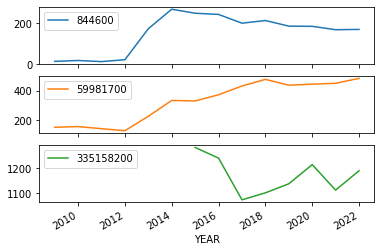

In [18]:
pd.pivot_table(transactions.reset_index(),index='YEAR',columns = 'ITEM_NUMBER',
               values = 'SOLDUNITS').plot(subplots=True)

In [19]:
transactions.groupby(['ITEM_NUMBER'])['SOLDUNITS'].describe()

,count,mean,std,min,25%,50%,75%,max
ITEM_NUMBER,,,,,,,,
844600,14149.0,200.624898,314.088986,0.28571,25.314290,65.400000,244.273970,3733.14286
59981700,59338.0,352.894320,482.061916,0.13342,64.656605,177.782545,405.727848,34217.02703
335158200,3922.0,1156.211129,451.852487,1.00000,1107.966670,1275.555560,1380.957500,2525.57778


844600            AxesSubplot(0.1,0.559091;0.363636x0.340909)
59981700     AxesSubplot(0.536364,0.559091;0.363636x0.340909)
335158200             AxesSubplot(0.1,0.15;0.363636x0.340909)
dtype: object

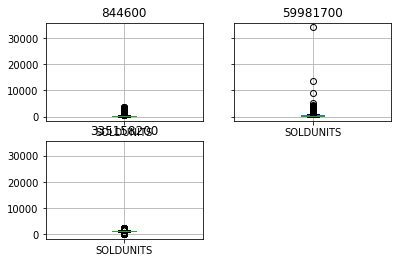

In [20]:
transactions.groupby('ITEM_NUMBER').boxplot(column='SOLDUNITS')

### Removing Outliers (ON HOLD)

In [21]:
res = transactions.groupby('ITEM_NUMBER')['SOLDUNITS'].quantile([0.05,0.95]).unstack(level=1)


In [22]:
res

,0.05,0.95
ITEM_NUMBER,,
844600,5.462776,839.114282
59981700,6.428570,1384.742860
335158200,234.336670,1762.500000


In [23]:
(res.loc[transactions.ITEM_NUMBER,0.05]<transactions.SOLDUNITS.values)&(transactions.SOLDUNITS.values<res.loc[transactions.ITEM_NUMBER,0.95])


ITEM_NUMBER
844600       False
844600        True
844600        True
844600        True
844600        True
             ...  
335158200     True
335158200     True
335158200     True
335158200     True
335158200     True
Length: 77409, dtype: bool

In [24]:
transactions.loc[((res.loc[transactions.ITEM_NUMBER,0.05] < transactions.SOLDUNITS.values) & (transactions.SOLDUNITS.values < res.loc[transactions.ITEM_NUMBER,0.95])).values]


,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
1,844600,8/16/13,15:16:10,15.60000,2013,8,33,16,0,3
2,844600,8/16/13,15:19:22,15.60000,2013,8,33,16,0,3
3,844600,8/16/13,17:04:11,716.91429,2013,8,33,16,0,3
4,844600,8/16/13,17:09:59,153.14286,2013,8,33,16,0,3
5,844600,8/5/16,8:57:51,557.60000,2016,8,31,5,0,3
...,...,...,...,...,...,...,...,...,...,...
77404,335158200,9/3/21,6:31:37,1311.13636,2021,9,35,3,0,4
77405,335158200,9/3/21,6:37:31,1564.11364,2021,9,35,3,0,4
77406,335158200,9/3/21,10:52:59,408.68182,2021,9,35,3,0,4
77407,335158200,9/3/21,11:09:33,408.68182,2021,9,35,3,0,4


### Scaling OR Normalization

In [25]:
scaler = preprocessing.MinMaxScaler()
scaledTrans = transactions.copy()
columnlist = ['SOLDUNITS','WEEK','IS_HOLIDAY','MONTH','SEASON']
column_names = transactions[columnlist]

In [26]:
d = scaler.fit_transform(column_names.values)
scaledTrans[columnlist] = d

In [27]:
scaledTrans.head()

,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
0,844600,8/14/13,8:40:14,0.000080,2013,0.636364,0.615385,14,0.0,0.666667
1,844600,8/16/13,15:16:10,0.000452,2013,0.636364,0.615385,16,0.0,0.666667
2,844600,8/16/13,15:19:22,0.000452,2013,0.636364,0.615385,16,0.0,0.666667
3,844600,8/16/13,17:04:11,0.020948,2013,0.636364,0.615385,16,0.0,0.666667
4,844600,8/16/13,17:09:59,0.004472,2013,0.636364,0.615385,16,0.0,0.666667


### Initial R2 scores

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

In [29]:
from sklearn.model_selection import train_test_split
predictors = transactions.drop(['DATE','SOLDUNITS','TIME'],axis=1)
target = transactions['SOLDUNITS']
x_train,x_cv,y_train,y_cv = train_test_split(predictors,target,test_size=0.4,random_state=1)

In [30]:
def scores(i):
    lin = i()
    lin.fit(x_train,y_train)
    y_pred = lin.predict(x_cv)
    lin_r=r2_score(y_cv,y_pred)
    s.append(lin_r)
    
algos = [LinearRegression,KNeighborsRegressor,RandomForestRegressor,Lasso,
        ElasticNet,DecisionTreeRegressor]
s =[]
for i in algos:
    scores(i)

In [31]:
models = pd.DataFrame({
    'Method': ['LinearRegression','KNeighborsRegressor',
              'RandomForestRegressor','Lasso','DecisionTreeRegressor'],
    'Score' : [s[0],s[1],s[2],s[3],s[4]]})
models.sort_values(by = 'Score',ascending = False)

,Method,Score
4,DecisionTreeRegressor,0.202638
0,LinearRegression,0.202474
3,Lasso,0.202454
2,RandomForestRegressor,0.157187
1,KNeighborsRegressor,0.073818


### Random Forest Regressor

In [32]:
model = RandomForestRegressor(oob_score = True, n_jobs = 1, random_state=7,
                             max_features = "auto",min_samples_leaf = 4)

In [33]:
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=1, oob_score=True,
                      random_state=7, verbose=0, warm_start=False)

In [34]:
pred = model.predict(x_cv)

In [35]:
r2_score(pred,y_cv)

-1.5585070693381322

In [36]:
def mean_percentage_error(y_cv,pred):
    y_cv,pred = np.array(y_cv),np.array(pred)
    return np.mean(np.array((y_cv - pred)/ y_cv))*100

In [37]:
mean_percentage_error(y_cv,pred)

-2112.9238358210123

### XGBoost

In [38]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error

In [39]:
train_x,test_x,train_y,test_y = train_test_split(predictors,target,
                                                      test_size = 0.3,random_state = 123)

In [40]:
print(train_x.shape,train_y.shape)

(54186, 7) (54186,)


In [41]:
lof = LocalOutlierFactor()
yhat = lof.fit_predict(train_x)

In [42]:
mask = yhat != -1
train_x,train_y = train_x.iloc[mask, :].values,train_y.iloc[mask].values
print(train_x.shape,train_y.shape)

(48319, 7) (48319,)


In [43]:
train_dmatrix = xg.DMatrix(data = train_x, label = train_y)
test_dmatrix = xg.DMatrix(data = test_x, label = test_y)

In [44]:
param = {"booster":"gblinear","objective":"reg:linear"}

In [45]:
xgb_r = xg.train(params = param, dtrain = train_dmatrix,
                num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)

[20:23:02] WARNING: /mnt/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'] ['ITEM_NUMBER', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'IS_HOLIDAY', 'SEASON']
expected f3, f4, f5, f1, f0, f2, f6 in input data
training data did not have the following fields: DAY, IS_HOLIDAY, WEEK, YEAR, MONTH, SEASON, ITEM_NUMBER

In [ ]:
rmse = np.sqrt(MSE(test_y,pred))
print("RMSE : % f" %(rmse))

In [ ]:
mae = mean_absolute_error(test_y, pred)
print('MAE: %.3f' % mae)

### Scoring and Regressor(On Hold)

In [46]:
model = XGBRegressor()

In [47]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [48]:
xgModel = XGBRegressor()

### Prophet

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [ ]:
df = transactions[['DATE','SOLDUNITS']].copy()

In [ ]:
df.rename(columns={'DATE': 'ds',
                   'SOLDUNITS': 'y'},
          inplace=True, errors='raise')

In [ ]:
df.head()

In [ ]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

plot_plotly(m, forecast)
plot_components_plotly(m, forecast)

In [ ]:
transactions.head()

In [ ]:
transactions.to_csv('../data/splitdates.csv')